---
# LeNet-5
---

In [1]:
# 라이브러리 불러오기
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


In [2]:
# 디바이스 설정
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('DEVICE:',device)

DEVICE: cpu


In [3]:
#이미지 다운로드, 전처리
trans = transforms.Compose([transforms.ToTensor(),
                           transforms.Resize(32)])

train_set = datasets.MNIST(root=r'C:\Users\Administrator\Desktop\Dataset',
                           transform=trans,
                           train=True,
                           download=True
                           )
test_set = datasets.MNIST(root=r'C:\Users\Administrator\Desktop\Dataset',
                           transform=trans,
                           train=False,
                           download=True
                           )

In [4]:
train_loader = DataLoader(dataset=train_set,
                          batch_size=64,
                          shuffle=True,
                          drop_last=True)

test_loader = DataLoader(dataset=test_set,
                          batch_size=len(test_set))

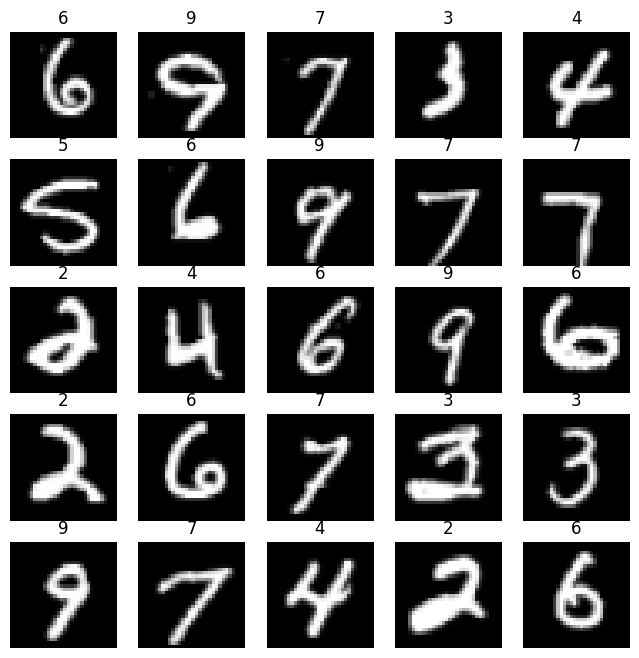

In [5]:
#이미지 시각화
fig = plt.figure(figsize=(8,8))

columns = 5
rows = 5

for i in range(1,columns*rows+1):
    img_xy = np.random.randint(len(train_set))
    img = train_set[img_xy][0][0]
    fig.add_subplot(rows,columns,i)
    plt.title(train_set[img_xy][1])
    plt.axis('off')
    plt.imshow(img,cmap='gray')
plt.show()

In [6]:
#모델 정의
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()

        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,stride=1),
            nn.Sigmoid()
        )

        self.sub_sampling_layer1 = nn.MaxPool2d(kernel_size=2,stride=2)

        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,stride=1),
            nn.Sigmoid()
        )

        self.sub_sampling_layer2 = nn.MaxPool2d(kernel_size=2,stride=2)

        self.flatten = nn.Flatten()

        self.fc_layer1 = nn.Sequential(
            nn.Linear(5*5*16,400),
            nn.Sigmoid()
            )
        
        self.fc_layer2 = nn.Sequential(
            nn.Linear(400,120),
            nn.Sigmoid()
            )
        
        self.fc_layer3 = nn.Sequential(
            nn.Linear(120,84),
            nn.Sigmoid()
            )
        
        self.output_layer = nn.Linear(84,10)
            

    def forward(self,x):
        x = self.conv_layer1(x)
        x = self.sub_sampling_layer1(x)
        x = self.conv_layer2(x)
        x = self.sub_sampling_layer2(x)
        x = self.flatten(x)
        x = self.fc_layer1(x)
        x = self.fc_layer2(x)
        x = self.fc_layer3(x)
        x = self.output_layer(x)
        return x

In [7]:
#하이퍼 파라미터 설정
model = LeNet().to(device)

num_epochs = 10
batch_size = 64
num_batchs = len(train_loader)

loss_func = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [10]:
train_set[0][0].shape

torch.Size([1, 32, 32])

In [ ]:
#학습 진행
for epoch in tqdm(range(num_epochs)):
    model.train()
    
    epoch_loss = 0.0
    epoch_correct_count = 0

    for data in tqdm(train_loader):
        optimizer.zero_grad()

        imgs,labels = data
        imgs,labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        batch_loss = loss_func(outputs,labels)

        epoch_loss += batch_loss/num_batchs
        epoch_correct_count += (outputs.argmax(dim=-1)==labels).sum().item()
        
        batch_loss.backward()
        optimizer.step()
    epoch_accuracy = epoch_correct_count/len(train_set)*100
    
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            val_imgs, val_labels = data
            val_imgs, val_labels = val_imgs.to(device), val_labels.to(device)

            val_outputs = model(val_imgs)
            val_loss = loss_func(val_outputs,val_labels)
            val_correct_count = (val_outputs.argmax(dim=-1)==val_labels).sum().item()
            val_accuracy = val_correct_count/len(test_set)*100

    print(f'[EPOCH {epoch+1:2}/{num_epochs:2}] [TRAIN LOSS: {epoch_loss:5f}] [TRAIN ACCURACY: {epoch_accuracy:2f}%] [VAL LOSS: {val_loss:5f}] [VAL ACCURACY: {val_accuracy:2f}%]')